# CS576 Assignment #3: Object Detection Using YOLO v1
---
Primary TA : 
* Wonkwang Lee (wonkwang.lee@kaist.ac.kr)
* Yoonki Cho (yoonki@kaist.ac.kr)
---

## Instruction
- In this assignment, you will implement, train, and test Yolo v1 on Pascal VOC Detection dataset with 20 object categories (`'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'`).

- For this, you need to implement (1) architecture, (2) loss function, (3) training/testing pipeline, and (4) inference function.

- In each part, you will be given a starter code for the implementation. Please read instructions carefully to implement the codes.  

- In this assignment, we will provide you with pre-trained weights of the Yolo architecture to reduce the amount of time required for the convergence and thus ease your burden on the training. This pre-trained weights will automatically loaded to your network if you implemented it correctly.


## Submission guidelines
- Your code and report will be all in Colab. 
- Go to the [link](https://drive.google.com/drive/folders/1Vap8ZUoTrlGq9Xp4ZHNgmVlG70HScCy6?usp=sharing), make a copy of `assignment3.ipynb`, `data.py`, `dataset.zip`, `test_images.zip`, and `weights` directory into your own google drive. Find the copies in your drive, recover their names to original ones if their names were changed to e.g. `Copy of assignment3.ipyb` or `assignment3.ipynb의 사본`. Also, keep them in a single directory.
- <font color="red"> You will get the full credit **only if** you complete the code **and** write a discussion of the results in the discussion section at the bottom of this page. </font>
- We should be able to reproduce your results using your code. Please double-check if your code runs without error and reproduces your results. Submissions failed to run or reproduce the results will get a substantial penalty. 

## Deliverables
- Your Colab notebook with name of **[StudentID].ipynb**
- Result images (`1_result.jpg`, `2_result.jpg`, ...). Please refer to Problem 4. 
- Saved checkpoint (`last.pth`). This will be saved automatically in your `checkpoints` directory. 
- Submit all of them in a format as : **[StudentID].zip**.
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions. 

## Due date
- **23:59:59 July 3th.**
- Late submission is allowed until 23:59:59 July 5th.
- Late submission will be applied 20% penalty.


## Questions
- Please use QnA board in KLMS as a main communication channel. When you post questions, please make it public so that all students can share the information. Please use the prefix "[Assignment 3]" in the subject for all questions regarding this assignment (e.g., [Assignment 3] Regarding the grading policy).

## Changelog

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
# Specify the directory path where `assignemnt3.ipynb` and `dataset.zip` exist.
# For example, if you saved `assignment3.ipynb` `/gdrive/My Drive/cs576/assignment3` directory,
# then set root = '/gdrive/My Drive/cs576/assignment3'
root = '/gdrive/My Drive/assignment3'

!ln -s '/gdrive/My Drive'/{root.replace('/gdrive/My Drive/', '')}/weights ./
!unzip -q '/gdrive/My Drive'/{root.replace('/gdrive/My Drive/', '')}/dataset.zip
!unzip -q '/gdrive/My Drive'/{root.replace('/gdrive/My Drive/', '')}/test_images.zip

In [ ]:
import sys
sys.path.append(root)

import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms

from data import VOCDetection
def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
# Configurations
run_name = 'vgg16'          # experiment name.
ckpt_root = 'checkpoints'   # from/to which directory to load/save checkpoints.
data_root = 'dataset'       # where the data exists.
pretrained_backbone_path = 'weights/vgg_features.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001 #0.001           # learning rate
batch_size = 64     # batch_size
last_epoch = 1      # the last training epoch. (defulat: 1)
max_epoch = 100 #200       # maximum epoch for the training.

num_bboxes = 2      # the number of boxes for each grid in Yolo v1.
num_classes = 20    # the number of classes in Pascal VOC Detection.
grid_size = 7       # 3x224x224 image is reduced to (5*num_boxes+num_classes)x7x7.
lambda_coord = 7    # weight for coordinate regression loss.
lambda_noobj = 0.5  # weight for no-objectness confidence loss.

ckpt_dir = os.path.join(root, ckpt_root)
makedirs(ckpt_dir)
!ln -s '/gdrive/My Drive'/{ckpt_dir.replace('/gdrive/My Drive/', '')} ./

In [ ]:
train_dset = VOCDetection(root=data_root, split='train')
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)

test_dset = VOCDetection(root=data_root, split='test')
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8)

In [ ]:
print(len(train_dset))
print(len(test_dset))

22129
4951


# Problem 1. Implement Architecture [(Illustration)](https://docs.google.com/drawings/d/1DNWgMK0XNQJ1IZPxX3u_ger7s-iQpAHG0pI_6A5dAPs/edit?usp=sharing)

In this section, you need to implement two modularized networks for Yolo v1:

(1) Backbone network of Yolo v1, extracting feature representations ($N, 512, 7, 7$) on input images ($N, 3, 224, 224$),  
(2) Detection network of Yolo v1, predicting object confidences, classes, and their locations based on grids ($N, S, S, B\times5+C$),

where $N, S, B, C$ refer to the batch size, grid size, the number of boxes for each grid, and the number of object classes, respectively.

Below, you will be provided with a skeleton python class for Yolo.  
Please fill in the `self.features = nn.Sequential(...)` and `self.detector = nn.Sequential(...)` to implement this module.

In [ ]:
class Yolo(nn.Module):
    def __init__(self, grid_size, num_bboxes, num_classes):
        super(Yolo, self).__init__()
        self.S = grid_size
        self.B = num_bboxes
        self.C = num_classes
        self.features = nn.Sequential(
            # implement backbone network here.
            nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            )

        self.detector = nn.Sequential(
            # implement detection head here.
            nn.Linear(in_features=self.S*self.S*512, out_features=4096, bias=True), 
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=self.S * self.S * (self.B * 5 + self.C), bias=True) 
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.detector(x)
        x = F.sigmoid(x)
        x = x.view(-1, self.S, self.S, self.B*5+self.C)
        return x

model = Yolo(grid_size, num_bboxes, num_classes)
model = model.to(device)
pretrained_weights = torch.load(pretrained_backbone_path)
model.load_state_dict(pretrained_weights)

# It should print out <All keys matched successfully> when you implemented VGG correctly.

<All keys matched successfully>

In [ ]:
# Freeze the backbone network.
model.features.requires_grad_(False)
model_params = [v for v in model.parameters() if v.requires_grad is True]
optimizer = optim.SGD(model_params, lr=lr, momentum=0.9, weight_decay=5e-4)

# Load the last checkpoint if exits.
ckpt_path = os.path.join(ckpt_dir, 'last.pth') 

if os.path.exists(ckpt_path):
  #try: 
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    last_epoch = ckpt['epoch'] + 1
    print('Last checkpoint is loaded. start_epoch:', last_epoch)
  #except EOFError:
    #print('Error')
else:
    print('No checkpoint is found.')

No checkpoint is found.


# Problem 2. Implement Loss Function

In this section, you need to implement code for computing losses in Yolo.  
Below, you will be provided with a skeleton module class, where you need to complete the forward function:  
`def forward(self, pred_tensor, target_tensor): 
...
return loss_xy, loss_wh, loss_obj, loss_noobj, loss_class`

where $N, S, B, C$ refer to the batch size, grid size, the number of boxes for each grid, and the number of object classes, respectively.

To get an easy picture on how `pred_tensor` and `target_tensor` look like, refer to the page 18~25 in [this slide](https://docs.google.com/presentation/d/1aeRvtKG21KHdD5lg6Hgyhx5rPq_ZOsGjG5rJ1HP7BbA/pub?start=false&loop=false&delayms=3000&slide=id.g137784ab86_4_1187)

Refer to the paper for more details about the loss function: https://arxiv.org/pdf/1506.02640.pdf

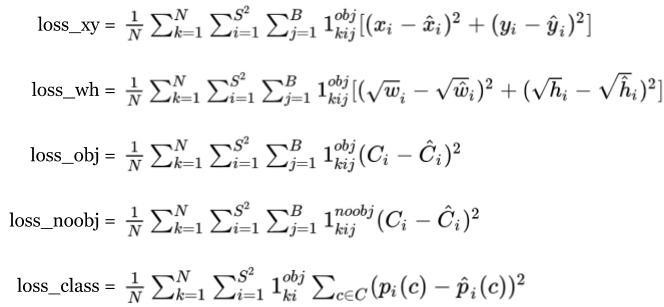

In [ ]:
#sOriginal
class Loss(nn.Module): 
    def __init__(self, grid_size=7, num_bboxes=2, num_classes=20):
        """ Loss module for Yolo v1.
        Use grid_size, num_bboxes, num_classes information if necessary.

        Args:
            grid_size: (int) size of input grid.
            num_bboxes: (int) number of bboxes per each cell.
            num_classes: (int) number of the object classes.
        """
        super(Loss, self).__init__()
        self.S = grid_size
        self.B = num_bboxes # assume there are two bounding boxes
        self.C = num_classes

    def compute_iou(self, bbox1, bbox2):
        """ Compute the IoU (Intersection over Union) of two set of bboxes, each bbox format: [x1, y1, x2, y2].
        Use this function if necessary.

        Args:
            bbox1: (Tensor) bounding bboxes, sized [N, 4].
            bbox2: (Tensor) bounding bboxes, sized [M, 4].
        Returns:
            (Tensor) IoU, sized [N, M].
        """
        #Right now, the bounding box attributes we have are described by the center coordinates, width and height. 
        #However, it's easier to calculate IoU of two boxes using corner coordinates. So we transform center coordinates 
        #to top-left and bottom-right coordinates

        box1_corner1 = bbox1[:,:2]-bbox1[:,2:]**2 # [N, (x1,y1)=2]
        box1_corner2 = bbox1[:,:2]+bbox1[:,2:]**2 # [N, (x2,y2)=2]
        box2_corner1 = bbox2[:,:2]-bbox2[:,2:]**2 # [M, (x1,y1)=2]
        box2_corner2 = bbox2[:,:2]+bbox2[:,2:]**2 # [M, (x2,y2)=2]
        bbox1 = torch.cat((box1_corner1.view(-1,2), box1_corner2.view(-1, 2)), dim=1) # [N,4], 4=[x1,y1,x2,y2]
        bbox2 = torch.cat((box2_corner1.view(-1,2), box2_corner2.view(-1, 2)), dim=1) # [M,4], 4=[x1,y1,x2,y2]

        N = bbox1.size(0)
        M = bbox2.size(0)

        tl = torch.max(
            bbox1[:,:2].unsqueeze(1).expand(N,M,2),  # [N,2] -> [N,1,2] -> [N,M,2]
            bbox2[:,:2].unsqueeze(0).expand(N,M,2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )
        br = torch.min(
            bbox1[:,2:].unsqueeze(1).expand(N,M,2),  # [N,2] -> [N,1,2] -> [N,M,2]
            bbox2[:,2:].unsqueeze(0).expand(N,M,2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )

        wh = br - tl  # [N,M,2]
        wh[(wh<0).detach()] = 0
        #wh[wh<0] = 0
        inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

        area1 = (bbox1[:,2]-bbox1[:,0]) * (bbox1[:,3]-bbox1[:,1])  # [N,]
        area2 = (bbox2[:,2]-bbox2[:,0]) * (bbox2[:,3]-bbox2[:,1])  # [M,]
        area1 = area1.unsqueeze(1).expand_as(inter)  # [N,] -> [N,1] -> [N,M]
        area2 = area2.unsqueeze(0).expand_as(inter)  # [M,] -> [1,M] -> [N,M]

        union = area1 + area2 - inter
        iou = inter / union
        return iou

    def forward(self, pred_tensor, target_tensor):
        """ Compute loss.

        Args:
            pred_tensor (Tensor): predictions, sized [batch_size, S, S, Bx5+C], 5=len([x, y, w, h, conf]).
            target_tensor (Tensor):  targets, sized [batch_size, S, S, Bx5+C].
        Returns:
            loss_xy (Tensor): localization loss for center positions (x, y) of bboxes.
            loss_wh (Tensor): localization loss for width, height of bboxes.
            loss_obj (Tensor): objectness loss.
            loss_noobj (Tensor): no-objectness loss.
            loss_class (Tensor): classification loss.
            OR
            total_loss = loss_xy + loss_wh + loss_obj + loss_noobj + loss_class
        """

        num_elements = self.B * 5 + self.C
        num_batch = target_tensor.size(0)

        target_tensor = target_tensor.view(-1, self.S*self.S, num_elements)
        pred_tensor = pred_tensor.view(-1, self.S*self.S,num_elements)
        
        mask_object = target_tensor[:,:,5] > 0
        mask_noobj = target_tensor[:,:,5] == 0
        mask_object = mask_object.unsqueeze(-1).expand_as(target_tensor)
        mask_noobj = mask_noobj.unsqueeze(-1).expand_as(target_tensor)

        target_object = target_tensor[mask_object].view(-1,num_elements)
        pred_object = pred_tensor[mask_object].view(-1,num_elements)
        target_class = target_object[:,self.B*5:]
        pred_class = pred_object[:,self.B*5:]
        target_box = target_object[:,:self.B*5].contiguous().view(-1,5)
        pred_box = pred_object[:,:self.B*5].contiguous().view(-1,5)
        

        target_noobj = target_tensor[mask_noobj].view(-1,num_elements)
        pred_noobj = pred_tensor[mask_noobj].view(-1,num_elements)

        # Compute loss for the cells with no object bbox
        # Extract conditional class probabilities
        noobj_conf_mask = torch.cuda.ByteTensor(target_noobj.size())
        noobj_conf_mask.zero_()
        for i in range(self.B):
            noobj_conf_mask[:,i*5+4] = 1
        target_noobj_cond = target_noobj[noobj_conf_mask] 
        pred_noobj_cond = pred_noobj[noobj_conf_mask]
       
        # loss for no object
        loss_noobj = F.mse_loss(pred_noobj_cond, target_noobj_cond, size_average=False, reduction='sum')

        #Computing loss for the cells that contain objects
        response_coord_mask = torch.cuda.ByteTensor(target_box.size())
        not_response_coord_mask = torch.cuda.ByteTensor(target_box.size())

        response_coord_mask.zero_()
        not_response_coord_mask = ~not_response_coord_mask.zero_()
        for i in range(0,target_box.size()[0],self.B):
            box1 = pred_box[i:i+self.B]
            box1_xyxy = Variable(torch.FloatTensor(box1.size())) # [B, 5=len([x1, y1, x2, y2, conf])]
            #rescaling (center_x,center_y) for the image-size so that we can compute IoU correctly.
            box1_xyxy[:, :2] = box1[:, 2]/float(self.S) - 0.5 * box1[:, 2:4]
            box1_xyxy[:, 2:4] = box1[:, 2]/float(self.S) + 0.5 * box1[:, 2:4]
  
            box2 = target_box[i] 
            box2 = target_box[i].view(-1, 5) # ith cell target bbox, [1, 5=len([x, y, w, h, conf])]
            box2_xyxy = Variable(torch.FloatTensor(box2.size()))
            box2_xyxy[:, :2] = box2[:, 2]/float(self.S) - 0.5 * box2[:, 2:4]
            box2_xyxy[:, 2:4] = box2[:, 2]/float(self.S) + 0.5 * box2[:, 2:4]



            iou = self.compute_iou(box1_xyxy[:, :4], box2_xyxy[:, :4])
            max_iou, max_index = iou.max(0)
            max_index = max_index.data.cuda()

            response_coord_mask[i+max_index]=1
            not_response_coord_mask[i+max_index]=0

        resp_pred_box = pred_box[response_coord_mask].view(-1, 5) 
        resp_target_box = target_box[response_coord_mask].view(-1, 5)

        # object loss
        loss_obj = F.mse_loss(resp_pred_box[:, 4], resp_target_box[:, 4], size_average=False, reduction='sum')

        
        #localization loss for x,y position of bboxes
        loss_xy = F.mse_loss(resp_pred_box[:, :2], resp_target_box[:, :2], size_average=False, reduction='sum')

        #localization loss for width and height of bboxes
        loss_wh = F.mse_loss(torch.sqrt(resp_pred_box[:, 2:4]), torch.sqrt(resp_target_box[:, 2:4]), size_average=False, reduction='sum')

        # loss w.r.t class prediction
        loss_class = F.mse_loss(pred_class, target_class, size_average=False, reduction='sum')

        # total loss
        #total_loss = loss_obj + loss_noobj + loss_class + loss_xy + loss_wh
        loss_obj = loss_obj/num_batch
        loss_noobj = loss_noobj/num_batch
        loss_class = loss_class/num_batch
        loss_xy = loss_xy/num_batch
        loss_wh = loss_wh/num_batch

        return loss_obj, loss_noobj, loss_class, loss_xy, loss_wh #total_loss/num_batch

# Problem 3. Implement Train/Test Pipeline

In this section, you need to implement the entire train and test loop in the pipeline.

Specifically, you need to do the followings:
1. set proper device for the inputs (x) / labels (y).
2. feed inputs into the network, get outputs, compute loss using your implemented loss function from problem 2.   
(Don't forget to aggregate them all to calculate a single final loss, using lambda_coord and lambda_noobj).
3. backward the computed loss and update network weights (only in the training loop).

In [ ]:
# Training & Testing.
model = model.to(device)
loss_list = []
loss_record = []
loss_list_test = []
loss_record_test = []

CRITERION = Loss(grid_size, num_bboxes, num_classes)

for epoch in range(1, max_epoch):
    # Learning rate scheduling
    if epoch in [40, 50]:
        lr *= 0.1
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    if epoch < last_epoch:
        continue

    # implement training pipeline here
    model.train()
    for i,(x,y) in enumerate(train_dloader):

        x = Variable(x).cuda(device)
        y = Variable(y).cuda(device)

        #forward to compute the loss
        pred = model(x)
        loss_obj, loss_noobj, loss_class, loss_xy, loss_wh = CRITERION(pred, y)
        loss = loss_obj + lambda_noobj*loss_noobj + loss_class + lambda_coord*(loss_wh + loss_xy)      
        #loss = CRITERION(pred,y)
        current_loss = loss
        loss_list.append(current_loss)

        #backward for updating the model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print("\r batch number %d/%d in epoch number %d/%d, current loss is %f"            % (i, len(train_dloader), epoch, max_epoch, current_loss))
            print(f"loss_obj={loss_obj}, loss_noobj={loss_noobj}, loss_class={loss_class}, loss_xy={loss_xy}, loss_wh={loss_wh}")
        loss_record.append(current_loss)

    model.eval()
    with torch.no_grad():
        for i,(x, y) in enumerate(test_dloader):
          # implement testing pipeline here
          x = Variable(x).cuda(device)
          y = Variable(y).cuda(device)

          pred = model(x)
          loss_obj, loss_noobj, loss_class, loss_xy, loss_wh = CRITERION(pred, y)
          loss = loss_obj + lambda_noobj*loss_noobj + loss_class + lambda_coord*(loss_wh + loss_xy)         
          #loss = CRITERION(pred,y)
          current_loss = loss
          loss_list_test.append(current_loss)

          if i % 10 == 0:
              print("\r batch number %d/%d in epoch number %d/%d, current loss is %f"            % (i, len(test_dloader), epoch, max_epoch, current_loss))
              print(f"loss_obj={loss_obj}, loss_noobj={loss_noobj}, loss_class={loss_class}, loss_xy={loss_xy}, loss_wh={loss_wh}")
          loss_record_test.append(current_loss)
    
    ckpt = {'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':epoch}
    torch.save(ckpt, ckpt_path)

 batch number 0/345 in epoch number 1/100, current loss is 27.225523
loss_obj=0.5188733339309692, loss_noobj=25.783676147460938, loss_class=9.908900260925293, loss_xy=0.3377901017665863, loss_wh=0.2201973795890808
 batch number 10/345 in epoch number 1/100, current loss is 9.222193
loss_obj=1.5223782062530518, loss_noobj=0.3766363561153412, loss_class=4.702271461486816, loss_xy=0.30036792159080505, loss_wh=0.10095003992319107
 batch number 20/345 in epoch number 1/100, current loss is 9.272551
loss_obj=1.9641145467758179, loss_noobj=0.13943180441856384, loss_class=3.2284634113311768, loss_xy=0.4208766222000122, loss_wh=0.152017280459404
 batch number 30/345 in epoch number 1/100, current loss is 8.969044
loss_obj=2.0355417728424072, loss_noobj=0.07626103609800339, loss_class=2.63930344581604, loss_xy=0.4495928883552551, loss_wh=0.1584169566631317
 batch number 40/345 in epoch number 1/100, current loss is 8.468685
loss_obj=1.9354902505874634, loss_noobj=0.11141033470630646, loss_class=

KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Problem 4. Implement decoder to extract bounding boxes from output-grids


In this section, you need to implement the decoder for extracting bounding boxes from given output grids ($S, S, B \times 5 + 20$). You should complete `decoder` function with given `NMS`(Non Max Suppression) function. 

If you implement it well, you can perform object dection on the given image and get the result through `inference` function.

Check `test_images` directory and find `X_result.jpg` files if you succeeded to run `inference` function, and attach these files in the discussion section

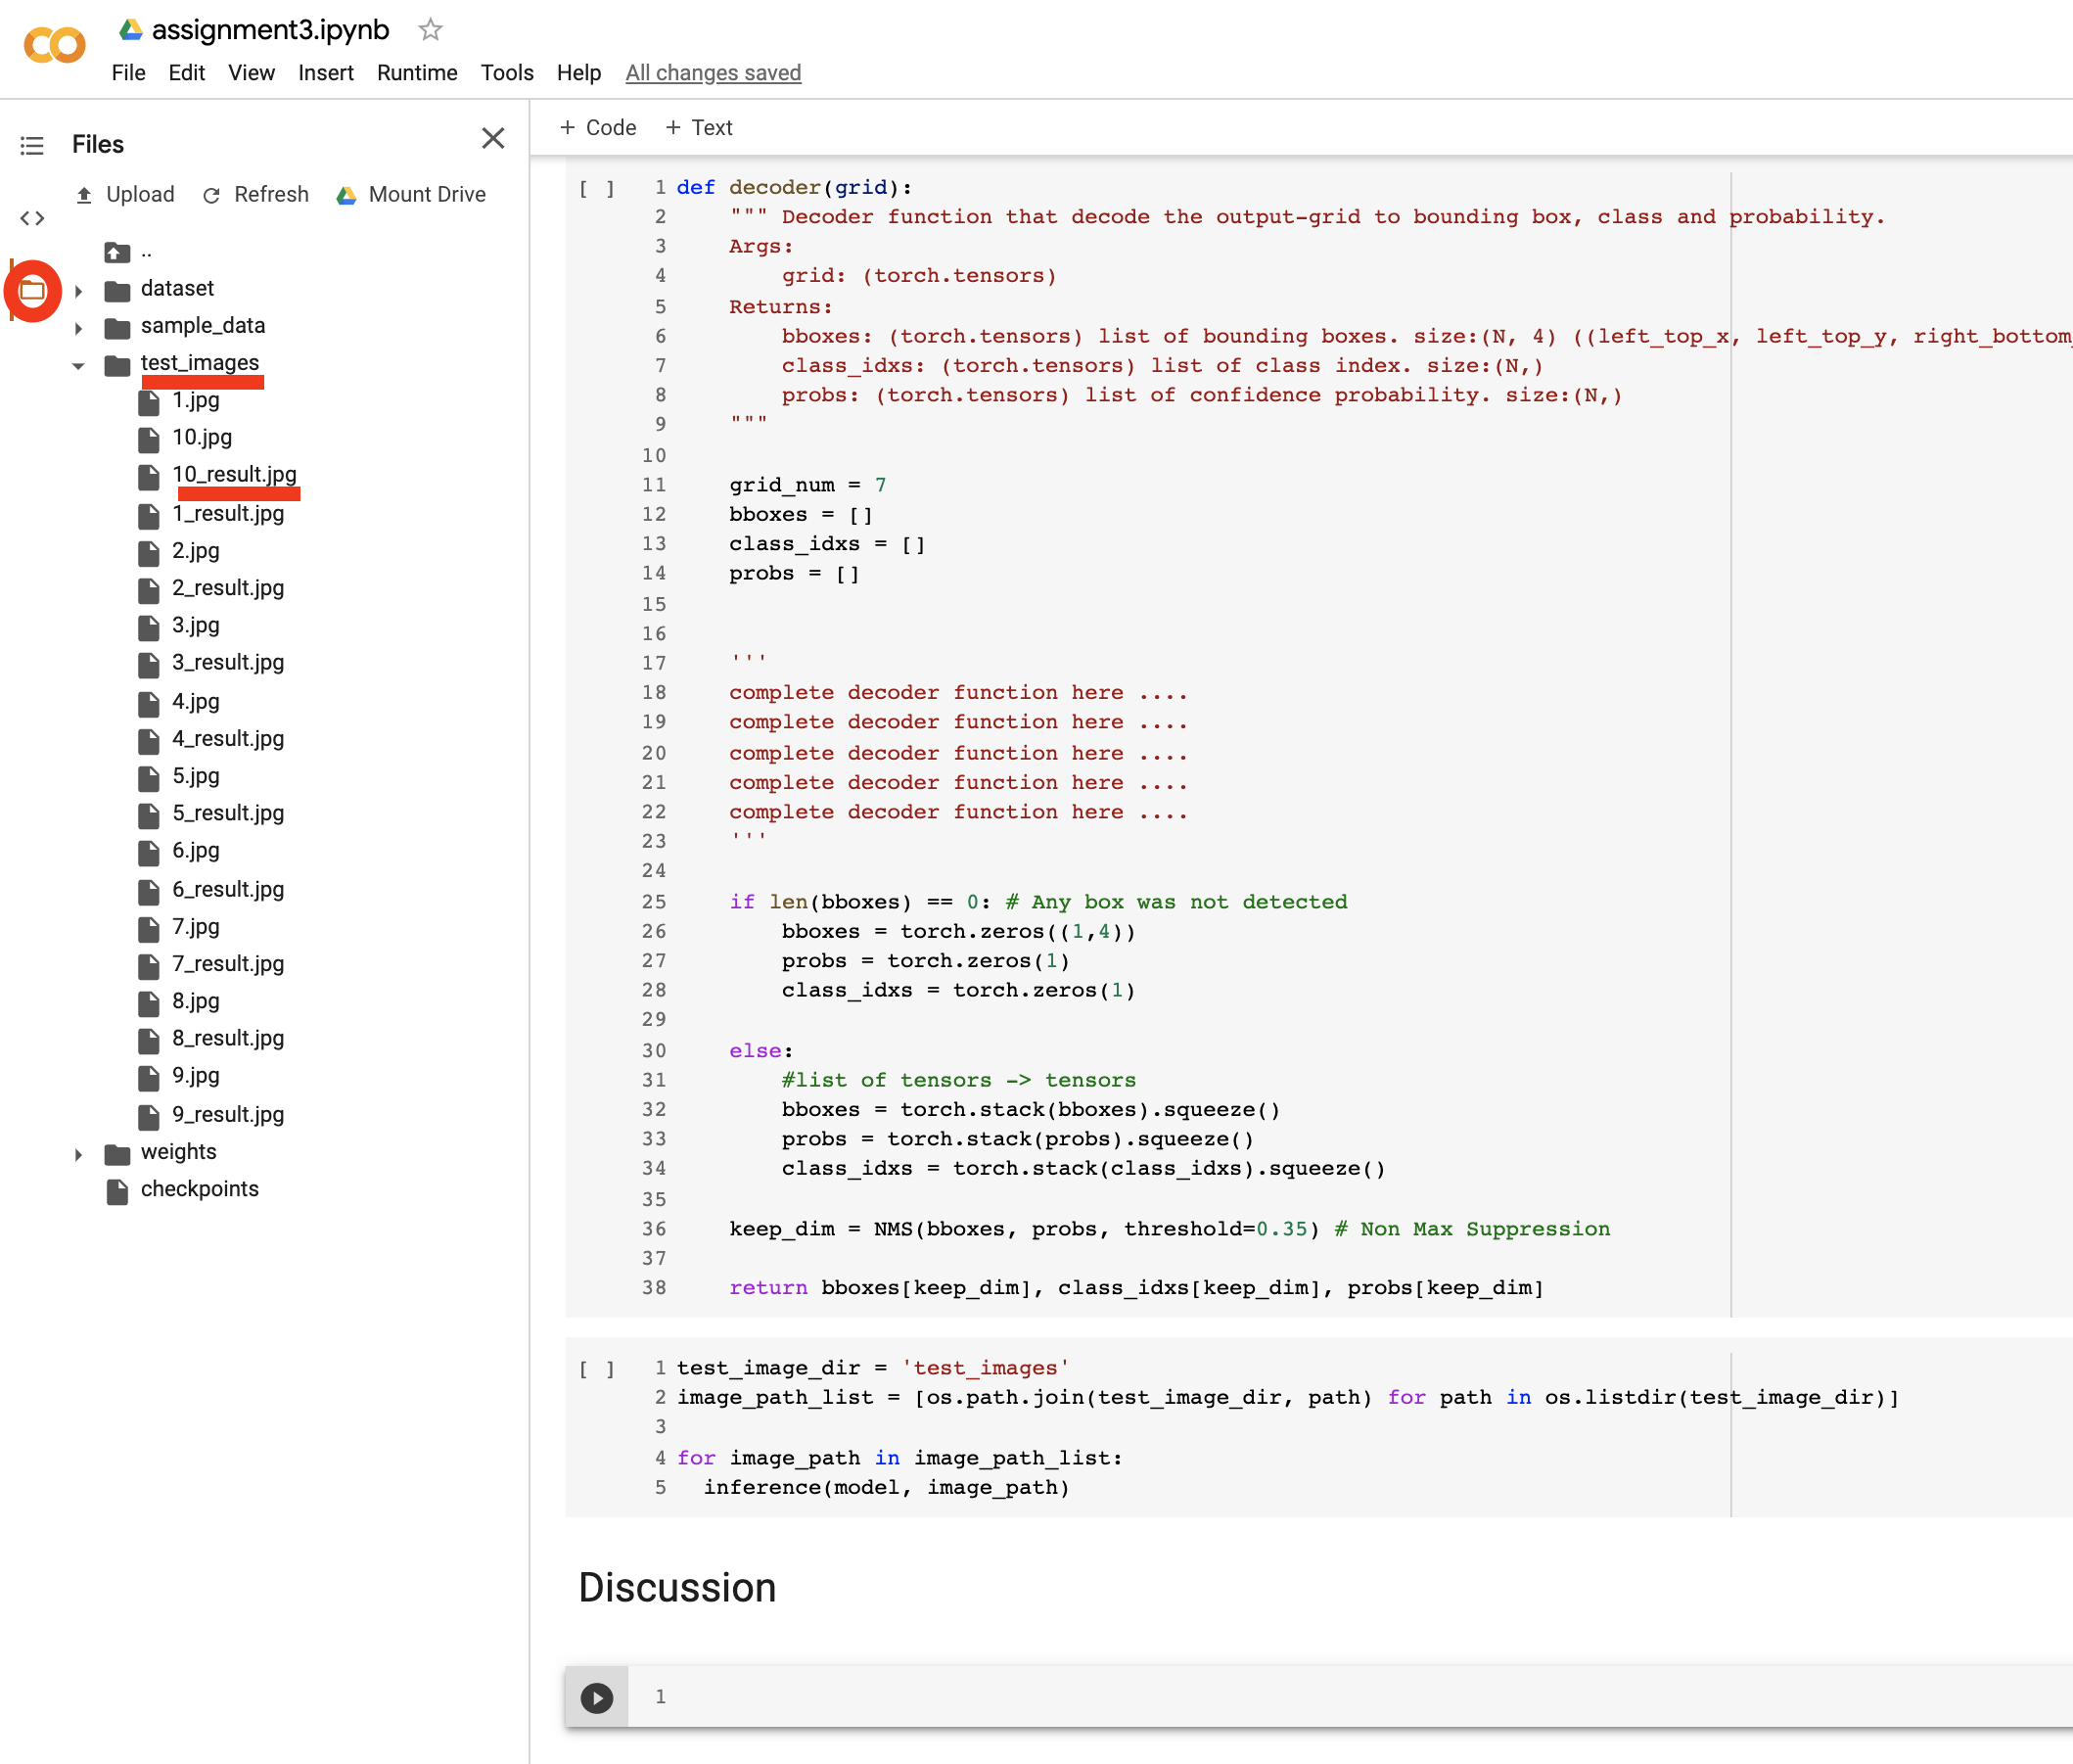

In [ ]:
VOC_CLASSES = (
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

def NMS(bboxes, scores, threshold=0.35):
    ''' Non Max Suppression
    Args:
        bboxes: (torch.tensors) list of bounding boxes. size:(N, 4) ((left_top_x, left_top_y, right_bottom_x, right_bottom_y), (...))
        probs: (torch.tensors) list of confidence probability. size:(N,) 
        threshold: (float)   
    Returns:
        keep_dim: (torch.tensors)
    '''
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)

    _, order = scores.sort(0, descending=True)
    keep = []
    while order.numel() > 0:
        try:
            i = order[0]
        except:
            i = order.item()
        keep.append(i)

        if order.numel() == 1: break

        xx1 = x1[order[1:]].clamp(min=x1[i])
        yy1 = y1[order[1:]].clamp(min=y1[i])
        xx2 = x2[order[1:]].clamp(max=x2[i])
        yy2 = y2[order[1:]].clamp(max=y2[i])

        w = (xx2 - xx1).clamp(min=0)
        h = (yy2 - yy1).clamp(min=0)
        inter = w * h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        ids = (ovr <= threshold).nonzero().squeeze()
        if ids.numel() == 0:
            break
        order = order[ids + 1]
    keep_dim = torch.LongTensor(keep)
    return keep_dim

In [ ]:
def inference(model, image_path):
    """ Inference function
    Args:
        model: (nn.Module) Trained YOLO model.
        image_path: (str) Path for loading the image.
    """
    # load & pre-processing
    image_name = image_path.split('/')[-1]
    image = cv2.imread(image_path)

    h, w, c = image.shape
    img = cv2.resize(image, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = transform(torch.from_numpy(img).float().div(255).transpose(2, 1).transpose(1, 0)) #Normalization
    img = img.unsqueeze(0)
    img = img.to(device)

    # inference
    #output_grid = model(img).cpu()
    output_grid = model(img).cpu()

    #### YOU SHOULD IMPLEMENT FOLLOWING decoder FUNCTION ####
    # decode the output grid to the detected bounding boxes, classes and probabilities.
    bboxes, class_idxs, probs = decoder(output_grid)
    num_bboxes = bboxes.size(0)
    #class_idxs = class_idxs.to(dtype=torch.long, device=device)

    # draw bounding boxes & class name
    for i in range(num_bboxes):
        bbox = bboxes[i]
        class_index = class_idxs[i]
        class_index = int(class_index)
        class_name = VOC_CLASSES[class_index]
        prob = probs[i]

        x1, y1 = int(bbox[0] * w), int(bbox[1] * h)
        x2, y2 = int(bbox[2] * w), int(bbox[3] * h)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, '%s: %.2f'%(class_name, prob), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1,
                    8)

    cv2.imwrite(image_name.replace('.jpg', '_result.jpg'), image)

In [ ]:
def decoder(grid):   
    """ Decoder function that decode the output-grid to bounding box, class and probability. 
    Args:
        grid: (torch.tensors)
    Returns:
        bboxes: (torch.tensors) list of bounding boxes. size:(N, 4) ((left_top_x, left_top_y, right_bottom_x, right_bottom_y), (...))
        class_idxs: (torch.tensors) list of class index. size:(N,)
        probs: (torch.tensors) list of confidence probability. size:(N,)
    """

    grid_num = 7
    bboxes=[]
    class_idxs=[]
    probs = []


    cell_size = 1./grid_num
    grid = grid.data
    grid = grid.squeeze(0) 
    cont_1 = grid[:,:,4].unsqueeze(2)
    cont_2 = grid[:,:,9].unsqueeze(2)
    contain = torch.cat((cont_1,cont_2),2)

    mask_1 = contain > 0.1 
    mask_2 = (contain==contain.max()) #Selecting the best probability
    mask = (mask_1+mask_2).gt(0)

    for i in range(grid_num):
        for j in range(grid_num):
            for b in range(2):

                if mask[i,j,b] == 1:
                    bbox = grid[i,j,b*5:b*5+4]
                    cont_prob = torch.FloatTensor([grid[i,j,b*5+4]])
                    xy = torch.FloatTensor([j,i])*cell_size #top-left pf the cell
                    bbox[:2] = bbox[:2]*cell_size + xy 
                    bbox_xy = torch.FloatTensor(bbox.size()) #To convert to [x1,y1,x2,y2]
                    bbox_xy[:2] = bbox[:2] - 0.5*bbox[2:]
                    bbox_xy[2:] = bbox[:2] + 0.5*bbox[2:]
                    prob_max,class_index = torch.max(grid[i,j,10:],0)
                    if float((cont_prob*prob_max)[0]) > 0.1:
                        bboxes.append(bbox_xy.view(1,4))
                        class_idxs.append(class_index)
                        probs.append(cont_prob*prob_max)
   
    '''if len(boxes) ==0:
        boxes = torch.zeros((1,4))
        probs = torch.zeros(1)
        class_idxs = torch.zeros(1)
    else:
        boxes = torch.stack(boxes,0) #(n,4)
        probs = torch.stack(probs,0) #(n,)
        class_idxs = torch.stack(class_idxs,0) #(n,)
    keep = NMS(boxes,probs)
    return boxes[keep],class_idxs[keep],probs[keep]'''

    if len(bboxes) == 0: # Any box was not detected
        bboxes = torch.zeros((1,4))
        probs = torch.zeros(1)
        class_idxs = torch.zeros(1)
        
    else: 
        #list of tensors -> tensors
        bboxes = torch.cat(bboxes,0)
        probs = torch.cat(probs,0)
        class_idxs = torch.stack(class_idxs,0)
        
    keep_dim = NMS(bboxes, probs, threshold=0.35) # Non Max Suppression

    return bboxes[keep_dim], class_idxs[keep_dim], probs[keep_dim]

In [ ]:
test_image_dir = 'test_images'
image_path_list = [os.path.join(test_image_dir, path) for path in os.listdir(test_image_dir)]

for image_path in image_path_list:
  inference(model, image_path)

# Discussion

**YOLO** (You only look once) is considered to be one of the state-of-the-art real-time object detectors. It is known for its good trade-off between the inference time and accuracy. Some of the observation on the PASCAL VOC results obtained aboved are mentioned below.



*   The model requires quite some time to train, specially on the cloud. However, many SOTA object detectors require huge training time.

*   I tested the  model for different number of epochs. After training the model for only for 10 epochs, it was observed that model did not recognize many categorize (mainly 'person' was recognized). The **confidence scores** were also very low. After training for 20 epochs, it recognized few more categories but score was still low.

*   However, after training the model for 50 epochs, we see some considerable results. The model seems to recognize almost all the categories. The confidence scores are also improved. There are some issues in 1 or 2 test images liek the model misses an aeroplane or a cat in another image. However, with more training model will further improve.

*   Another important thing as mentioned earlier is that the model seems to perform better on some categories than others. The confidence score for 'person' and 'aeroplane' category seems to be higher compared to the rest. This might be due to the discrepany in training dataset.

*   The inference time is very short as expect. That is one of the main reason why Yolo is famous compared to other object detectors especially for real-time tasks.

*   Due too large training time, it was hard to train the model on cloud for large number of epochs. I ran it once for 50 epochs. A few times I tried to run it for 100 epochs but it failed around 80 epochs due to disconnection or timeout issue.

*   Inference results after 50 epochs training are attached below.

*   Currently I am also training it again for 100 epochs but this time offline on local GPU. I will also attach those results for comparison purposes once the training is done.


**Inference result images (50 epochs):**

Image1: (https://drive.google.com/uc?export=view&id=1GyUGmk-yldyZKqITVSlgk8IEbXtkKcYd)

Image2: (https://drive.google.com/uc?export=view&id=1agiyjiCiw-jkHQj9CV58ABau8sptzOli)

Image3: (https://drive.google.com/uc?export=view&id=1TzIAeMkah-JDmiUBJuzWIfBjOcELsGNG)

Image4: (https://drive.google.com/uc?export=view&id=1CiSMO4bRxoTq4kn79sDD16pZ6vywFBzS)

Image5: (https://drive.google.com/uc?export=view&id=1Bm7vRBEe_zZ6TN2sf9LNcaZM8OgThxVC)

Image6: (https://drive.google.com/uc?export=view&id=1T6MAPuk04qU-tic6fJl2ZZyG5ky3b0KR)

Image7: (https://drive.google.com/uc?export=view&id=1coeZP6Ihsd5_cwMz0Iwcm2qaOmTrYZad)

Image8: (https://drive.google.com/uc?export=view&id=18P4VR6oNdDOpxafqmEpR5pFXRI8HFgiM)

Image9: (https://drive.google.com/uc?export=view&id=1LR9n4Pb0dwpekHbH0YNWb3PuxoUdqnVn)


**Inference result images (100 epochs):**

Image1: (https://drive.google.com/uc?export=view&id=1vgLNFrK5HEJqJ_NGdzegPOiM8x3TLcji)

Image2: (https://drive.google.com/uc?export=view&id=11oofuAETMtyMZm8zvqxtdP4TWU_sQYKR)

Image3: (https://drive.google.com/uc?export=view&id=1ejn2T-6_uK_vdsTGYQwvPDAz9nOKSuhS)

Image4: (https://drive.google.com/uc?export=view&id=1XSPvr3wWpHlootUCUBdMCLOvUpK60qwR)

Image5: (https://drive.google.com/uc?export=view&id=1e8uGcBICZc3OGrRwKqqGngGNtdlx0ii5)

Image6: (https://drive.google.com/uc?export=view&id=1BsAjJ4AiFWrcMPV6EUn7x2fp0HZXiYLB)

Image7: (https://drive.google.com/uc?export=view&id=1SwhCQo0H0s23gb_C_rD19bR8Ma42qfYx)

Image8: (https://drive.google.com/uc?export=view&id=11e66QzRP08arTx2BjiMq63JPvJ5eKG2q)

Image9: (https://drive.google.com/uc?export=view&id=1_gTj0_fhhwR3OJSPIQtCuAGdR9UdG6jh)

Image10: (https://drive.google.com/uc?export=view&id=1Xr87tqI7rJy0ESz6zosGtj4iRt8zDka6)


Result comparison show that 100 epoch result shave little higher confidence score in some cases but the performance improvement is not huge compared to 50 epochs.






